# Building a comments classification mode
For each class, we build a Logistic Regression model with TF-IDF features. Data taken from Kaggle: [https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data).


In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [2]:
CLASS_NAMES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

We start with data from Kaggle:

In [3]:
train = pd.read_csv('data/train.csv').fillna(' ')
test = pd.read_csv('data/test.csv').fillna(' ')
test_labels = pd.read_csv('data/test_labels.csv').fillna(' ')

In [4]:
train['non-toxic'] = (~train[CLASS_NAMES].any(axis=1)).astype(int)

In [5]:
train.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
135949,d730d7fd1acae98b,Do not re-add spam links again. Thank you. P...,0,0,0,0,0,0,1
18168,30009f769a6c8559,"October 2008 (UTC)\n\nLangdell, you can not le...",0,0,0,0,0,0,1
42577,719ebfbea89fec49,"People like you are the problem, Brangifer. Y...",0,0,0,0,0,0,1


In [6]:
train.loc[train['identity_hate'] == 1].sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
130910,bc7895d8c7b2c54e,"""*a-hem*... """"nigger nigger nigger, nigger nig...",1,0,1,0,1,1,0
130633,bace7305a84ac7c7,fuk you fucked up sinhalese motherfucking assh...,1,1,1,0,1,1,0
132382,c4647e8a0eb2c11a,Ronald McDonald is gay and he has a fart fetis...,1,0,1,0,1,1,0


In [7]:
train.shape

(159571, 9)

In [8]:
test.sample(3)

,id,comment_text
8269,0dda1ca286c1f35b,"""Dylan Wooley-Berry is a Canadian Collegiate s..."
5730,09af907c9eb2033a,"""== Justin evans == \n A tag has been placed o..."
101515,a96ca8c91c02ea1c,""" \n\n :Cite is now provided. There's no short..."


In [9]:
train_text = train['comment_text']
test_text = test['comment_text']

Fit a word vectorizer on all the comments we have at hand.

In [10]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000
)
word_vectorizer.fit(train_text)

train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [23]:
{k: v for k, v in word_vectorizer.vocabulary_.items() if v in [0, 2039, 2950]}

{'0': 0, 'collins': 2039, 'diseases': 2950}

Fit a character vectorizer on all the comments we have at hand.

In [12]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 4),
    max_features=20000
)
char_vectorizer.fit(train_text)

train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [24]:
{k: v for k, v in char_vectorizer.vocabulary_.items() if v in [0, 2039, 2950]}

{'/or ': 2950, '"i ': 2039, '\n"': 0}

Combine char and word features.

In [13]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [17]:
train_features.get_shape(), test_features.get_shape()

((159571, 30000), (153164, 30000))

In [27]:
[k for k, v in char_vectorizer.vocabulary_.items() if v == 0]

['\n"']

In [25]:
(pd.Series(train_features.getcol(0).toarray().reshape(-1)) == 0).value_counts()

True     158395
False      1176
dtype: int64

Perform cross-validation.

In [ ]:
models = {}

for class_name in CLASS_NAMES:
    train_target = train[class_name]
    classifier = LogisticRegressionCV(Cs=[0.1], cv=5, dual=False, scoring='roc_auc', solver='sag')
    classifier.fit(train_features, train_target)
    models[class_name] = classifier


In [33]:
models

{'toxic': LogisticRegressionCV(Cs=[0.1], class_weight=None, cv=5, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='warn', n_jobs=None, penalty='l2',
            random_state=None, refit=True, scoring='roc_auc', solver='sag',
            tol=0.0001, verbose=0),
 'severe_toxic': LogisticRegressionCV(Cs=[0.1], class_weight=None, cv=5, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='warn', n_jobs=None, penalty='l2',
            random_state=None, refit=True, scoring='roc_auc', solver='sag',
            tol=0.0001, verbose=0),
 'obscene': LogisticRegressionCV(Cs=[0.1], class_weight=None, cv=5, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='warn', n_jobs=None, penalty='l2',
            random_state=None, refit=True, scoring='roc_auc', solver='sag',
            tol=0.0001, verbose=0),
 'threat': LogisticRegressionCV(Cs=[0

In [53]:
m.scores_[1].reshape(-1)

array([0.9724251 , 0.97258355, 0.97069525, 0.97141919, 0.97128841])

In [55]:
for class_name in CLASS_NAMES:
    print('{} mean AUC: {}'.format(
        class_name, 
        np.mean(np.array(models[class_name].scores_[1].reshape(-1)))
    ))

toxic mean AUC: 0.971682299732801
severe_toxic mean AUC: 0.9877693212643962
obscene mean AUC: 0.9862245238251386
threat mean AUC: 0.98335366420886
insult mean AUC: 0.9789689302246039
identity_hate mean AUC: 0.9760638090125587


Serialise the model and vectorizers for later usage.

In [58]:
model_dict = {
    'word_vectorizer': word_vectorizer,
    'char_vectorizer': char_vectorizer,
    'models': models
}

In [190]:
import pickle
import sklearn
print(pickle.format_version)
print(sklearn.__version__)
with open('models/models_dict.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

4.0
0.20.3


### Check out the predictions

In [130]:
def classify_comment(comment, word_vectorizer, char_vectorizer, models, probability=False, return_df=False):
    """
    :param comment: a string, the raw data to score
    """
    word_features = word_vectorizer.transform([comment])
    char_features = char_vectorizer.transform([comment])
    combined_features = hstack([char_features, word_features])
    
    prediction = {}
    for class_name, model in models.items():
        if probability:
            # Take the positive class probability prediction
            class_prediction = model.predict_proba(combined_features)[0][1]
        else:
            class_prediction = model.predict(combined_features)[0]
            
        prediction[class_name] = [class_prediction]
    
    if return_df:
        return  pd.DataFrame(prediction)
    else:
        return prediction


In [116]:
train.loc[6, 'comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [117]:
classify_comment(train.loc[6, 'comment_text'], word_vectorizer, char_vectorizer, models)

{'toxic': [1],
 'severe_toxic': [0],
 'obscene': [1],
 'threat': [0],
 'insult': [1],
 'identity_hate': [0]}

In [118]:
classify_comment(train.loc[6, 'comment_text'], word_vectorizer, char_vectorizer, models, probability=True)

{'toxic': [0.8585041205136328],
 'severe_toxic': [0.07667344189353084],
 'obscene': [0.6610377139745154],
 'threat': [0.006208220279737111],
 'insult': [0.5310307917522255],
 'identity_hate': [0.017713994964651685]}

In [131]:
classify_comment(train.loc[6, 'comment_text'], word_vectorizer, char_vectorizer, models, probability=True, return_df=True)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.858504,0.076673,0.661038,0.006208,0.531031,0.017714


## Look at our model probability distributions

In [120]:
all_text = pd.concat([train_text, test_text], axis=0)

In [160]:
def score_all(comments, word_vectorizer, char_vectorizer, models, probability=False):
    """
    :param comments: a numpy array or pandas `Series` of comments.
    """
    word_features = word_vectorizer.transform(comments)
    char_features = char_vectorizer.transform(comments)
    combined_features = hstack([char_features, word_features])
    
    predictions = {}
    for class_name, model in models.items():
        if probability:
            # Take the positive class probability prediction
            class_predictions = model.predict_proba(combined_features)[:, 1]
        else:
            class_predictions = model.predict(combined_features)
            
        predictions[class_name] = class_predictions
        
    return pd.DataFrame(predictions)

In [161]:
probs = score_all(all_text, word_vectorizer, char_vectorizer, models, probability=True)

In [162]:
labels = score_all(all_text, word_vectorizer, char_vectorizer, models, probability=False)

In [166]:
all_text = pd.concat(
    [
        all_text.reset_index(drop=True),
        probs.reset_index(drop=True),
        labels.reset_index(drop=True)
    ],
    axis=1
)

In [172]:
all_text.columns = ['comment_text'] + [x+'_prob' for x in CLASS_NAMES] + [x+'_pred' for x in CLASS_NAMES]

In [189]:
all_text.sample(3)

,comment_text,toxic_prob,severe_toxic_prob,obscene_prob,threat_prob,insult_prob,identity_hate_prob,toxic_pred,severe_toxic_pred,obscene_pred,threat_pred,insult_pred,identity_hate_pred
165118,Re: You people are incredibly stupid...,0.905300,0.021020,0.289689,0.005241,0.646615,0.030147,1,0,0,0,1,0
112538,"""\n""""cannon or cannon bone: The area between t...",0.025285,0.002531,0.012835,0.001531,0.011896,0.004578,0,0,0,0,0,0
232237,==Licenciranje slika== \n Kada dodajes logoe n...,0.086077,0.007417,0.039037,0.003205,0.040271,0.011650,0,0,0,0,0,0


In [185]:
import matplotlib.pyplot as plt

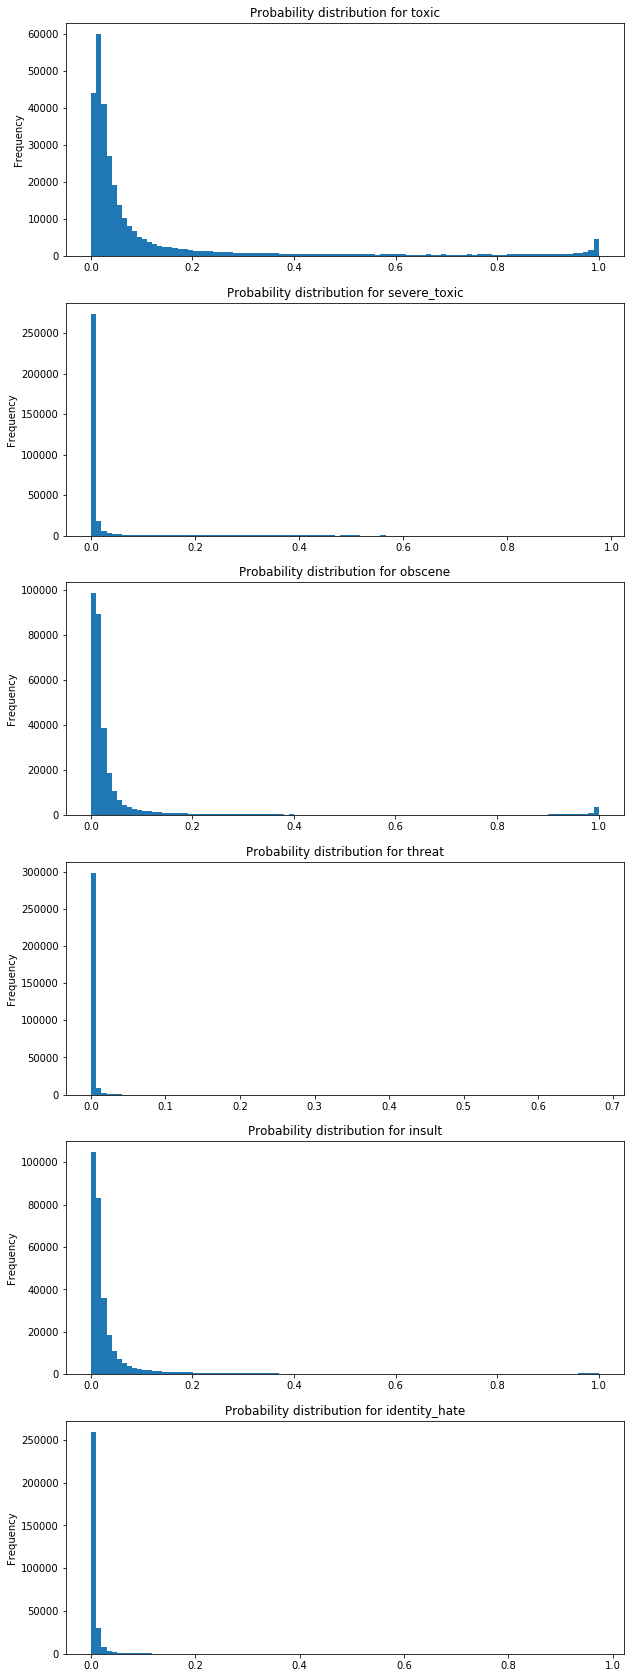

In [186]:
_, ax = plt.subplots(len(CLASS_NAMES), 1, figsize=(10,5*len(CLASS_NAMES)))

for i, class_name in enumerate(CLASS_NAMES):
    all_text[class_name+'_prob'].plot(kind='hist', bins=100, ax=ax[i])
    ax[i].set_title('Probability distribution for {}'.format(class_name))

plt.show()